# Spark
## Linear Regression
### Consulting Project

In [1]:
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style='darkgrid')
sns.set_context("notebook", rc={"lines.linewidth": 2.5})

In [2]:
random_seed = 1234

In [3]:
spark = SparkSession.builder.appName('lr_consulting_project').getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/11/02 20:08:58 WARN Utils: Your hostname, Diego-desktop resolves to a loopback address: 127.0.1.1; using 172.27.76.109 instead (on interface eth0)
23/11/02 20:08:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/02 20:09:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
data = spark.read.csv('../data/cruise_ship_info.csv', header=True, inferSchema=True)
data.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [5]:
data.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [6]:
data.groupBy('Cruise_line').count().orderBy('count').show()

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|           Orient|    1|
|          Crystal|    2|
|           Disney|    2|
|          Azamara|    2|
|           Cunard|    3|
|         Seabourn|    3|
|         Windstar|    3|
|          Oceania|    3|
|        Silversea|    4|
|Regent_Seven_Seas|    5|
|              P&O|    6|
|             Star|    6|
|              MSC|    8|
|        Celebrity|   10|
|            Costa|   11|
|        Norwegian|   13|
| Holland_American|   14|
|         Princess|   17|
|         Carnival|   22|
|  Royal_Caribbean|   23|
+-----------------+-----+



In [7]:
data.select(F.collect_set('Ship_name')).first()[0]

['MarcoPolo',
 'Atlantica',
 'Glory',
 'Pacific',
 'Explorer',
 'Xpedition',
 'Virgo',
 'Summit',
 'Maasdam',
 'Musica',
 'Victory',
 'Marina',
 'Fascination',
 'Monarch',
 'Inspiration',
 'Royal',
 'Pride',
 'Ventura',
 'Regal',
 'Gem',
 'Veendam',
 'Mercury',
 'Triumph',
 'Westerdam',
 'Century',
 'Classica',
 'Freedom',
 'Rhapsody',
 'Dawn',
 'Regatta',
 'Liberty*',
 'Valor',
 'Infinity',
 'Holiday',
 'Enchantment',
 'Liberty',
 'Ryndam',
 'Melody',
 'Artemis',
 'Island',
 'Oosterdam',
 'Caribbean',
 'Rotterdam',
 'Amsterdam',
 'Oriana',
 'Majesty',
 'Eurodam',
 'Arcadia',
 'Voyager',
 'Brilliance',
 'Allegra',
 'Statendam',
 'Quest',
 'Armonia',
 'Crown',
 'Libra',
 'Magica',
 'Zuiderdam',
 'Radiance',
 'Splendour',
 'Taurus',
 'Empress',
 'Aurora',
 'Sea',
 'Conquest',
 'Coral',
 'Diamond',
 'Adventure',
 'Journey',
 'Vision',
 'Opera',
 'Millenium',
 'Symphony',
 'QueenVictoria',
 'Fortuna',
 'PaulGauguin',
 'Imagination',
 'Spirit',
 'ExplorerII',
 'Elation',
 'Independence',
 '

In [8]:
data.select(F.collect_set('Cruise_line')).first()[0]

['Disney',
 'Royal_Caribbean',
 'Crystal',
 'P&O',
 'Celebrity',
 'Holland_American',
 'MSC',
 'Carnival',
 'Star',
 'Princess',
 'Azamara',
 'Norwegian',
 'Regent_Seven_Seas',
 'Cunard',
 'Silversea',
 'Windstar',
 'Costa',
 'Orient',
 'Seabourn',
 'Oceania']

In [9]:
len(data.select(F.collect_set('Cruise_line')).first()[0])

20

In [10]:
indexer = StringIndexer(inputCol='Cruise_line', outputCol='Cruise_line_index').fit(data)
new_data = indexer.transform(data)
new_data.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_index|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|              1.0|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|              1.0|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|              1.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|       

In [11]:
new_data.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew',
 'Cruise_line_index']

In [12]:
features = [
    'Age',
    'Tonnage',
    'passengers',
    'length',
    'cabins',
    'passenger_density',
    'Cruise_line_index',
]

target = 'crew'

In [13]:
assembler = VectorAssembler(
    inputCols=features,
    outputCol='features',   
)

In [14]:
new_data = assembler.transform(new_data)
new_data.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- Cruise_line_index: double (nullable = false)
 |-- features: vector (nullable = true)



In [15]:
new_data.show(5)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+--------------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_index|            features|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+--------------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|[6.0,30.276999999...|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|[6.0,30.276999999...|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|              1.0|[26.0,47.262,14.8...|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|              1.0|[11.0,110.0,29.74...|
|    Destiny|   Carnival| 17|           101.353|

In [16]:
master_table = new_data.select('crew', 'features')
master_table.show(5)

+----+--------------------+
|crew|            features|
+----+--------------------+
|3.55|[6.0,30.276999999...|
|3.55|[6.0,30.276999999...|
| 6.7|[26.0,47.262,14.8...|
|19.1|[11.0,110.0,29.74...|
|10.0|[17.0,101.353,26....|
+----+--------------------+
only showing top 5 rows



In [17]:
master_table.describe().show()

+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              158|
|   mean|7.794177215189873|
| stddev|3.503486564627034|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+



In [18]:
train, test, val = master_table.randomSplit([0.7, 0.2, 0.1], seed=random_seed)

In [19]:
train.describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|               104|
|   mean|7.6593269230769225|
| stddev|3.5539597127227616|
|    min|               0.6|
|    max|              21.0|
+-------+------------------+



In [20]:
test.describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|                38|
|   mean| 7.771578947368421|
| stddev|3.6954460845571995|
|    min|              0.59|
|    max|              19.1|
+-------+------------------+



In [21]:
val.describe().show()

+-------+----------------+
|summary|            crew|
+-------+----------------+
|  count|              16|
|   mean|        8.724375|
| stddev|2.64688488290166|
|    min|             4.0|
|    max|            13.6|
+-------+----------------+



In [22]:
LinearRegression?

Init signature:
LinearRegression(
    *,
    featuresCol: str = 'features',
    labelCol: str = 'label',
    predictionCol: str = 'prediction',
    maxIter: int = 100,
    regParam: float = 0.0,
    elasticNetParam: float = 0.0,
    tol: float = 1e-06,
    fitIntercept: bool = True,
    standardization: bool = True,
    solver: str = 'auto',
    weightCol: Optional[str] = None,
    aggregationDepth: int = 2,
    loss: str = 'squaredError',
    epsilon: float = 1.35,
    maxBlockSizeInMB: float = 0.0,
)
Docstring:     
Linear regression.

The learning objective is to minimize the specified loss function, with regularization.
This supports two kinds of loss:

* squaredError (a.k.a squared loss)
* huber (a hybrid of squared error for relatively small errors and absolute error for     relatively large ones, and we estimate the scale parameter from training data)

This supports multiple types of regularization:

* none (a.k.a. ordinary least squares)
* L2 (ridge regression)
* L1 (Lasso)
* L

In [23]:
iters = 100
lambda_list = 10 ** np.linspace(-4, 4, iters)

model_list = []
test_error_list = []
train_error_list = []

for i, lamb in enumerate(lambda_list):
    
    model = LinearRegression(
        featuresCol='features',
        labelCol='crew',
        predictionCol='prediction',
        elasticNetParam=0,
        regParam = lamb,
    )
    
    model = model.fit(train)
    
    train_error = model.evaluate(train).rootMeanSquaredError
    test_error = model.evaluate(test).rootMeanSquaredError
    
    train_error_list.append(train_error)
    test_error_list.append(test_error)

In [24]:
from operator import itemgetter

RMSE_min_index, RMSE_min = min(enumerate(test_error_list), key=itemgetter(1))

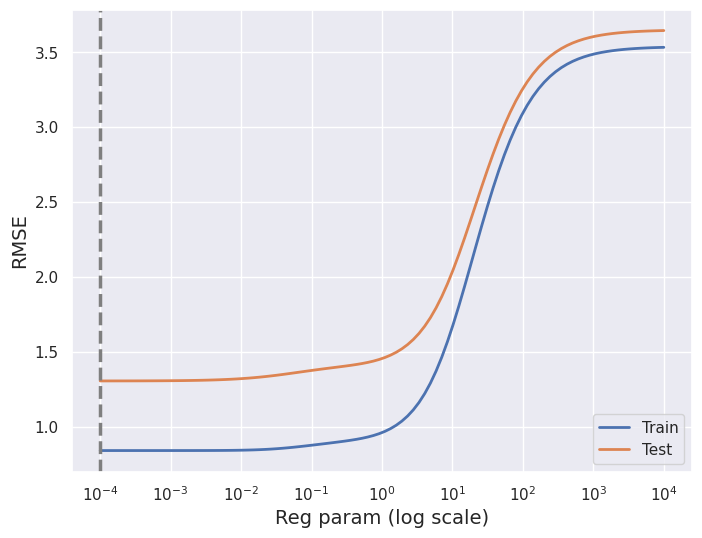

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(lambda_list, train_error_list, linewidth=2, label='Train')
ax.plot(lambda_list, test_error_list, linewidth=2, label='Test')

ax.axvline(x=lambda_list[RMSE_min_index], color="tab:gray", linestyle="--")

ax.set_xscale('log')
ax.set_ylabel('RMSE', size=14)
ax.set_xlabel('Reg param (log scale)', size=14)

plt.legend()
plt.show()

In [26]:
best_lambda = lambda_list[RMSE_min_index]
best_lambda

0.0001

In [34]:
model = LinearRegression(
    featuresCol='features',
    labelCol='crew',
    predictionCol='prediction',
    elasticNetParam=0,
    regParam = best_lambda,
)

full_train = train.union(test)

model = model.fit(full_train)

model_eval = model.evaluate(val)

In [35]:
model_eval.rootMeanSquaredError

0.5824097858847005

In [29]:
model_eval.meanAbsoluteError

0.4705188963594588

In [30]:
model_eval.r2

0.9487630534713353

In [31]:
model.coefficients

DenseVector([-0.0126, 0.0082, -0.144, 0.4425, 0.8512, -0.0029, 0.0546])

In [32]:
data.describe().show()

23/11/02 20:10:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       NULL|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|     NULL|       NULL| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

In [33]:
print(f'Correlation with {target}')
for feature in features:
    corr_val = new_data.select(F.corr(target, feature)).collect()[0][0]
    print(f'\t{feature} : {corr_val}')
    

Correlation with crew


	Age : -0.5306565039638852
	Tonnage : 0.927568811544939
	passengers : 0.9152341306065384
	length : 0.8958566271016579
	cabins : 0.9508226063578497
	passenger_density : -0.15550928421699717
	Cruise_line_index : -0.5154627327113319
